# COVID-19 Data Analysis
- Data is provided Johns Hopkins University <a href='https://github.com/CSSEGISandData/COVID-19'>here</a>

In [1]:
# Import libraries
import shutil
import os
import stat
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from tensorflow import keras
import numpy as np
import folium
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
# Declare important variables
raw_data_path = 'raw_data/'
confirmed_data_path = raw_data_path + 'csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
death_data_path = raw_data_path + 'csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
recovered_data_path = raw_data_path + 'csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

In [3]:
# Run this cell to get latest data
def handle_remove_readonly(func, path, exc):
    if not os.access(path, os.W_OK):
        # Is the error an access error ?
        os.chmod(path, stat.S_IWUSR)
        func(path)
    else:
        raise
        
if(os.path.exists(raw_data_path)):
    shutil.rmtree(raw_data_path, onerror=handle_remove_readonly)
    
!git clone https://github.com/CSSEGISandData/COVID-19.git $raw_data_path

Cloning into 'raw_data'...


## Data Analysis
### Worldwide cases analytic

In [4]:
# Declare dataframe
df_confirmed = pd.read_csv(confirmed_data_path)
df_death = pd.read_csv(death_data_path)
df_recovered = pd.read_csv(recovered_data_path)

In [5]:
# Covid cases distribution
map_view = folium.Map(location=[10,0], zoom_start=2,max_zoom=6,min_zoom=2)
for i in range(0,len(df_confirmed)):
    folium.Circle(
        location=[df_confirmed.iloc[i]['Lat'], df_confirmed.iloc[i]['Long']],
        tooltip = "<h5 style='text-align:center;font-weight: bold'>"+df_confirmed.iloc[i]['Country/Region']+"</h5>"+
                    "<div style='text-align:center;'>"+str(np.nan_to_num(df_confirmed.iloc[i]['Province/State']))+"</div>"+
                    "<hr style='margin:10px;'>"+
                    "<ul style='color: #444;list-style-type:circle;align-item:left;padding-left:20px;padding-right:20px'>"+
        "<li>Confirmed: "+str(df_confirmed.iloc[i,-1])+"</li>"+
        "</ul>"
        ,
        radius=(int((np.log(df_confirmed.iloc[i,-1]+1.00001))))*20000,
        color='#ffaf7a',
        fill_color='#ffaf7a').add_to(map_view)

map_view

In [6]:
dates = df_confirmed.columns[4:]

Text(0.5, 0, 'Number of confirmed cases (updated: 5/12/20)')

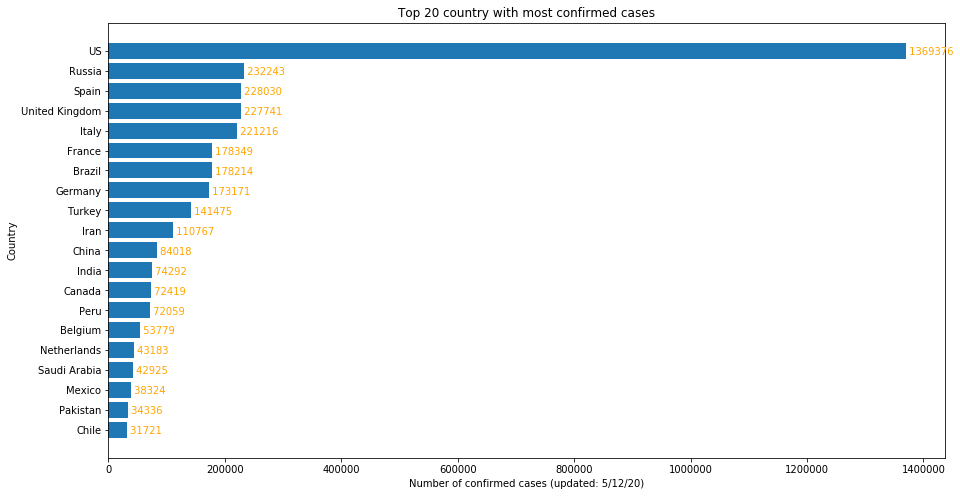

In [7]:
# Sum the amount of cases in different state group by country
df_confirmed_country = df_confirmed.groupby('Country/Region')[dates].sum().reset_index()
df_confirmed_country = df_confirmed_country.sort_values(by=df_confirmed_country.columns[-1], ascending=False)

# Plot the chart for top 20 most confirmed cases
plt.figure(figsize=(15,8))
plt.barh(df_confirmed_country[df_confirmed_country.columns[0]].iloc[:20][::-1], 
         df_confirmed_country[df_confirmed_country.columns[-1]].iloc[:20][::-1])
for i, v in enumerate(df_confirmed_country[df_confirmed_country.columns[-1]].iloc[:20][::-1]):
    plt.text(v, i-.2, ' '+str(v), color='orange')
plt.title('Top 20 country with most confirmed cases')
plt.ylabel('Country')
plt.xlabel(f'Number of confirmed cases (updated: {df_confirmed_country.columns[-1]})')

Text(0.5, 0, 'Number of death cases (updated: 5/12/20)')

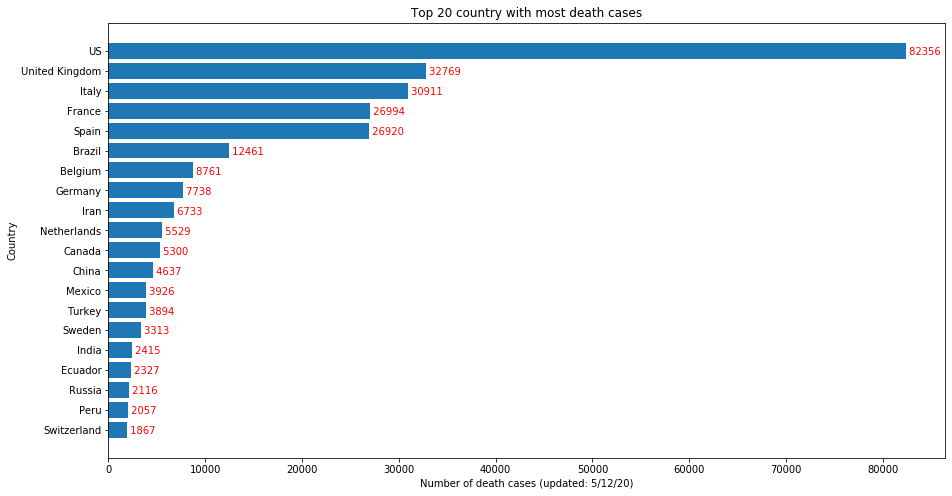

In [8]:
# Sum the amount of cases in different state group by country
df_death_country = df_death.groupby('Country/Region')[dates].sum().reset_index()
df_death_country = df_death_country.sort_values(by=df_death_country.columns[-1], ascending=False)

# Plot the chart for top 20 most death cases
plt.figure(figsize=(15,8))
plt.barh(df_death_country[df_death_country.columns[0]].iloc[:20][::-1], 
         df_death_country[df_death_country.columns[-1]].iloc[:20][::-1])
for i, v in enumerate(df_death_country[df_death_country.columns[-1]].iloc[:20][::-1]):
    plt.text(v, i-.2, ' '+str(v), color='red')
plt.title('Top 20 country with most death cases')
plt.ylabel('Country')
plt.xlabel(f'Number of death cases (updated: {df_death_country.columns[-1]})')

Text(0.5, 0, 'Number of recovered cases (updated: 5/12/20)')

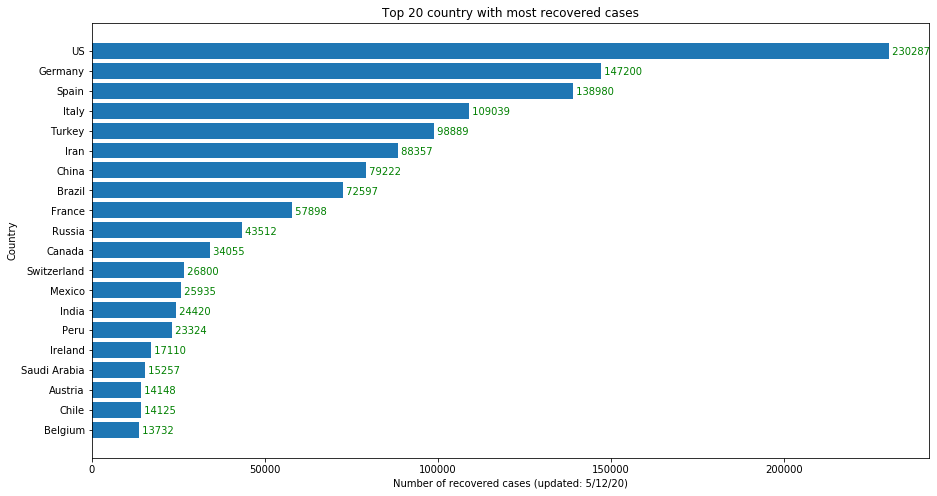

In [9]:
# Sum the amount of cases in different state group by country
df_recovered_country = df_recovered.groupby('Country/Region')[dates].sum().reset_index()
df_recovered_country = df_recovered_country.sort_values(by=df_recovered_country.columns[-1], ascending=False)

# Plot the chart for top 20 most recovered cases
plt.figure(figsize=(15,8))
plt.barh(df_recovered_country[df_recovered_country.columns[0]].iloc[:20][::-1], 
         df_recovered_country[df_recovered_country.columns[-1]].iloc[:20][::-1])
for i, v in enumerate(df_recovered_country[df_recovered_country.columns[-1]].iloc[:20][::-1]):
    plt.text(v, i-.2, ' '+str(v), color='green')
plt.title('Top 20 country with most recovered cases')
plt.ylabel('Country')
plt.xlabel(f'Number of recovered cases (updated: {df_recovered_country.columns[-1]})')

In [10]:
# Aggregate the latest number for confirmed, death and recovered cases for each country
df_agg = df_confirmed_country.iloc[:,[0,-1]].rename(columns={'Country/Region':'country',dates[-1]:'confirmed'})
df_agg = df_agg.join(df_death_country.iloc[:,[0,-1]].set_index('Country/Region'), 
                     on='country').rename(columns={dates[-1]:'death'})
df_agg = df_agg.join(df_recovered_country.iloc[:,[0,-1]].set_index('Country/Region'), 
                     on='country').rename(columns={dates[-1]:'recovered'})
df_agg.head(2)

,country,confirmed,death,recovered
173,US,1369376,82356,230287
139,Russia,232243,2116,43512


In [11]:
# Calculate the current active cases and rate of death and recovered
df_agg['current_active'] = df_agg['confirmed'] - df_agg['death'] - df_agg['recovered']
df_agg['death_rate'] = round((df_agg['death'] / df_agg['confirmed']) * 100, 2)
df_agg['recovered_rate'] = round((df_agg['recovered'] / df_agg['confirmed']) * 100, 2)
df_agg.head(2)

,country,confirmed,death,recovered,current_active,death_rate,recovered_rate
173,US,1369376,82356,230287,1056733,6.01,16.82
139,Russia,232243,2116,43512,186615,0.91,18.74


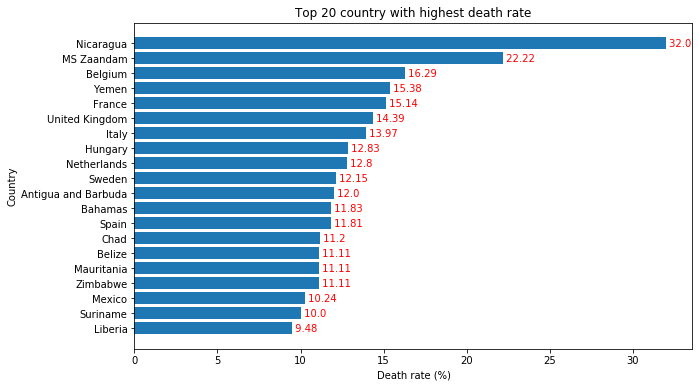

In [12]:
df_agg.sort_values(by='death_rate', inplace=True)

# Plot top 20 highest death rate
plt.figure(figsize=(10,6))
plt.barh(df_agg['country'].iloc[-20:], df_agg['death_rate'].iloc[-20:])
plt.title("Top 20 country with highest death rate")
plt.xlabel("Death rate (%)")
plt.ylabel("Country")

for i, v in enumerate(df_agg['death_rate'].iloc[-20:]):
    plt.text(v, i-.2, ' '+str(v), color='red')

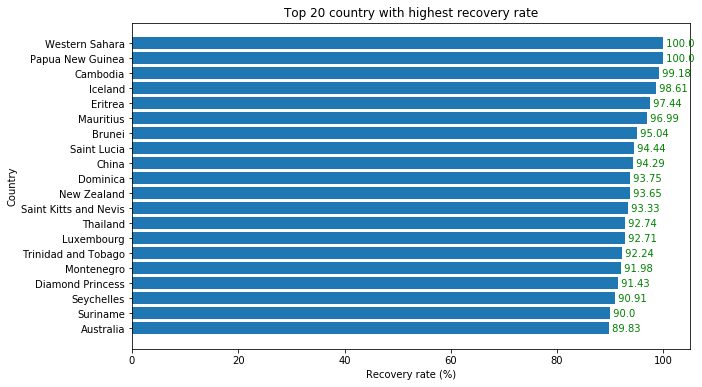

In [13]:
df_agg.sort_values(by='recovered_rate', inplace=True)

# Plot top 20 highest recovery rate
plt.figure(figsize=(10,6))
plt.barh(df_agg['country'].iloc[-20:], df_agg['recovered_rate'].iloc[-20:])
plt.title("Top 20 country with highest recovery rate")
plt.xlabel("Recovery rate (%)")
plt.ylabel("Country")

for i, v in enumerate(df_agg['recovered_rate'].iloc[-20:]):
    plt.text(v, i-.2, ' '+str(v), color='green')

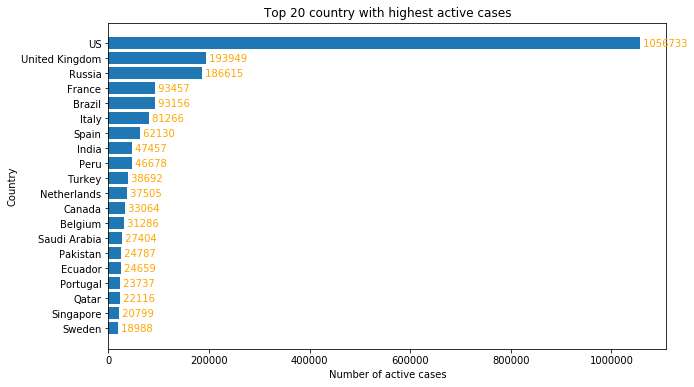

In [14]:
df_agg.sort_values(by='current_active', inplace=True)

# Plot top 20 highest active case
plt.figure(figsize=(10,6))
plt.barh(df_agg['country'].iloc[-20:], df_agg['current_active'].iloc[-20:])
plt.title("Top 20 country with highest active cases")
plt.xlabel("Number of active cases")
plt.ylabel("Country")

for i, v in enumerate(df_agg['current_active'].iloc[-20:]):
    plt.text(v, i-.2, ' '+str(v), color='orange')

In [15]:
df_agg.sort_values(by='current_active', ascending=False, inplace=True)
df_agg.style.background_gradient(cmap='Reds')

,country,confirmed,death,recovered,current_active,death_rate,recovered_rate
173,US,1369376,82356,230287,1056733,6.01,16.82
177,United Kingdom,227741,32769,1023,193949,14.39,0.45
139,Russia,232243,2116,43512,186615,0.91,18.74
62,France,178349,26994,57898,93457,15.14,32.46
23,Brazil,178214,12461,72597,93156,6.99,40.74
85,Italy,221216,30911,109039,81266,13.97,49.29
157,Spain,228030,26920,138980,62130,11.81,60.95
79,India,74292,2415,24420,47457,3.25,32.87
133,Peru,72059,2057,23324,46678,2.85,32.37
172,Turkey,141475,3894,98889,38692,2.75,69.9


### Malaysia Cases Analytic

In [16]:
# Extract Malaysia time series data
my_confirmed = df_confirmed[df_confirmed['Country/Region'] == 'Malaysia'][dates].values.flatten()
my_recovered = df_recovered[df_recovered['Country/Region'] == 'Malaysia'][dates].values.flatten()
my_death = df_death[df_death['Country/Region'] == 'Malaysia'][dates].values.flatten()
my_active = my_confirmed - my_recovered - my_death

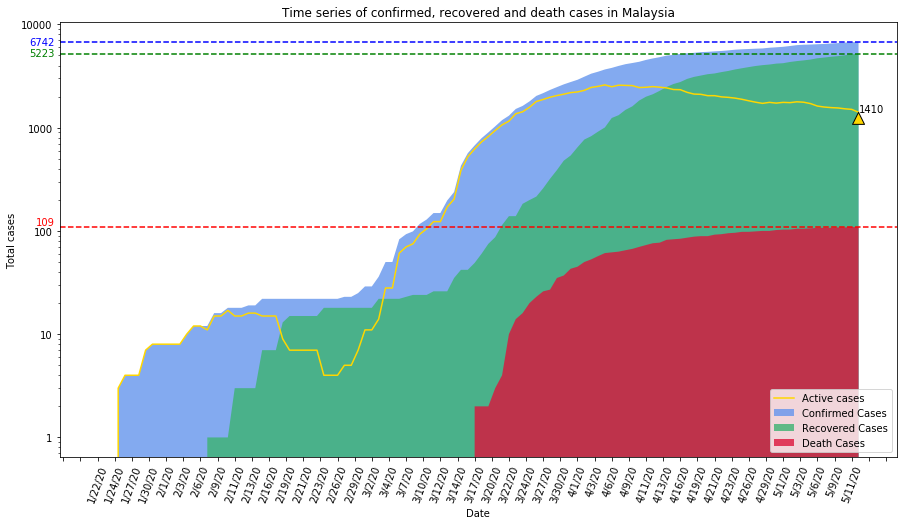

In [17]:
# Plot chart of cases in Malaysia
plt.figure(figsize=(15,8))

plt.fill_between(dates, my_confirmed, facecolor='cornflowerBlue', alpha=0.8, label='Confirmed Cases')
plt.fill_between(dates, my_recovered, facecolor='mediumSeaGreen', alpha=0.8, label='Recovered Cases')
plt.fill_between(dates, my_death, facecolor='crimson', alpha=0.8, label='Death Cases')
plt.plot(dates, my_active, color='gold', label='Active cases')

plt.axhline(y=my_confirmed[-1], color='blue', linestyle='--')
plt.axhline(y=my_recovered[-1], color='green', linestyle='--')
plt.axhline(y=my_death[-1], color='red', linestyle='--')
plt.text(-10, my_confirmed[-1], my_confirmed[-1], color='blue', va='center')
plt.text(-10, my_recovered[-1], my_recovered[-1], color='green', va='center')
plt.text(-9, my_death[-1] + 5, my_death[-1], color='red')
plt.annotate(s=my_active[-1], xy=(dates[-1], my_active[-1]), arrowprops=dict(facecolor='gold', shrink=0.05))

plt.yscale('log')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=50))
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.xticks(rotation=70)
plt.title('Time series of confirmed, recovered and death cases in Malaysia')
plt.xlabel('Date')
plt.ylabel('Total cases')
plt.legend()

## Predictive Model

In [18]:
# previous sequences used in LSTM
prev_day = 14

In [19]:
keras.backend.clear_session()

in_data = keras.Input((prev_day,1),dtype='float32')

X = keras.layers.LSTM(units=128,return_sequences=True)(in_data)
X = keras.layers.Dropout(0.2)(X)
X = keras.layers.LSTM(units=64,return_sequences=True)(X)
X = keras.layers.Dropout(0.2)(X)
X = keras.layers.LSTM(units=32)(X)
X = keras.layers.Dropout(0.2)(X)
X = keras.layers.Dense(32, activation='relu')(X)
X = keras.layers.Dense(16, activation='relu')(X)
X = keras.layers.Dense(1, activation='relu')(X)

# Create Model instance which converts sentence_indices into X.
model = keras.models.Model(inputs=in_data, outputs=X)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 14, 1)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 14, 128)           66560     
_________________________________________________________________
dropout (Dropout)            (None, 14, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 14, 64)            49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0     

In [20]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [21]:
# Create training input for lstm
# train_x = []
# train_y = []
# for i in reversed(range(21, len(my_case_increament))):
#     train_x.append(my_case_increament[i-21:i-1])
#     train_y.append(my_case_increament[i])
# train_x = np.array(train_x).reshape(len(train_x), 20, 1).astype(float)
# train_y = np.array(train_y).astype(float)

my_cul = df_confirmed[df_confirmed['Country/Region'] == 'Malaysia'].to_numpy()[0, 4:]
features = [my_cul[i:i+prev_day]for i in range(0, len(my_cul)-prev_day,1)]
label = my_cul[prev_day:]
features = np.array(features).reshape(len(features),prev_day,1).astype(float)
label = np.array(label).reshape(len(label),1).astype(float)

X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.1)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(88, 14, 1) (10, 14, 1) (88, 1) (10, 1)


In [22]:
history = model.fit(x=X_train, y=y_train, epochs=3000, batch_size=32, validation_split=0.05)

Train on 83 samples, validate on 5 samples
Epoch 1/3000
83/83 [==============================] - 9s 107ms/sample - loss: 13465558.4096 - val_loss: 14973822.0000
Epoch 2/3000
83/83 [==============================] - 0s 2ms/sample - loss: 13463976.2229 - val_loss: 14971606.0000
Epoch 3/3000
83/83 [==============================] - 0s 2ms/sample - loss: 13462078.0181 - val_loss: 14969664.0000
Epoch 4/3000
83/83 [==============================] - 0s 2ms/sample - loss: 13460227.1928 - val_loss: 14967742.0000
Epoch 5/3000
83/83 [==============================] - 0s 2ms/sample - loss: 13458905.2651 - val_loss: 14965746.0000
Epoch 6/3000
83/83 [==============================] - 0s 2ms/sample - loss: 13456889.4096 - val_loss: 14963397.0000
Epoch 7/3000
83/83 [==============================] - 0s 2ms/sample - loss: 13454376.8916 - val_loss: 14960762.0000
Epoch 8/3000
83/83 [==============================] - 0s 2ms/sample - loss: 13452144.1205 - val_loss: 14957851.0000
Epoch 9/3000
83/83 [=======

83/83 [==============================] - 0s 2ms/sample - loss: 12163432.4096 - val_loss: 13433622.0000
Epoch 71/3000
83/83 [==============================] - 0s 2ms/sample - loss: 12094447.8072 - val_loss: 13373492.0000
Epoch 72/3000
83/83 [==============================] - 0s 2ms/sample - loss: 12073415.7470 - val_loss: 13312317.0000
Epoch 73/3000
83/83 [==============================] - 0s 2ms/sample - loss: 11980680.3554 - val_loss: 13249369.0000
Epoch 74/3000
83/83 [==============================] - 0s 2ms/sample - loss: 11908731.9036 - val_loss: 13185991.0000
Epoch 75/3000
83/83 [==============================] - 0s 4ms/sample - loss: 11813486.6747 - val_loss: 13103388.0000
Epoch 76/3000
83/83 [==============================] - 0s 3ms/sample - loss: 11822635.2771 - val_loss: 13098132.0000
Epoch 77/3000
83/83 [==============================] - 0s 3ms/sample - loss: 11722965.6506 - val_loss: 12961999.0000
Epoch 78/3000
83/83 [==============================] - 0s 2ms/sample - loss: 1

83/83 [==============================] - 0s 3ms/sample - loss: 5390678.5482 - val_loss: 6076931.5000
Epoch 141/3000
83/83 [==============================] - 0s 2ms/sample - loss: 5190512.4006 - val_loss: 5975238.0000
Epoch 142/3000
83/83 [==============================] - 0s 2ms/sample - loss: 5018726.0843 - val_loss: 5876623.5000
Epoch 143/3000
83/83 [==============================] - 0s 2ms/sample - loss: 4993370.7681 - val_loss: 5780987.0000
Epoch 144/3000
83/83 [==============================] - 0s 2ms/sample - loss: 4688679.1084 - val_loss: 5690861.0000
Epoch 145/3000
83/83 [==============================] - 0s 2ms/sample - loss: 4592102.2861 - val_loss: 5599881.5000
Epoch 146/3000
83/83 [==============================] - 0s 2ms/sample - loss: 4648353.5602 - val_loss: 5511723.5000
Epoch 147/3000
83/83 [==============================] - 0s 2ms/sample - loss: 4465875.6747 - val_loss: 5424842.0000
Epoch 148/3000
83/83 [==============================] - 0s 2ms/sample - loss: 4406660.7

Epoch 211/3000
83/83 [==============================] - 0s 2ms/sample - loss: 1801346.5753 - val_loss: 4123223.2500
Epoch 212/3000
83/83 [==============================] - 0s 2ms/sample - loss: 1872241.6401 - val_loss: 4131844.5000
Epoch 213/3000
83/83 [==============================] - 0s 2ms/sample - loss: 2064534.9036 - val_loss: 4140615.2500
Epoch 214/3000
83/83 [==============================] - 0s 2ms/sample - loss: 1907334.7108 - val_loss: 4150088.0000
Epoch 215/3000
83/83 [==============================] - 0s 3ms/sample - loss: 1839189.6386 - val_loss: 4158183.2500
Epoch 216/3000
83/83 [==============================] - 0s 2ms/sample - loss: 2023923.1777 - val_loss: 4164082.5000
Epoch 217/3000
83/83 [==============================] - 0s 2ms/sample - loss: 1934313.2319 - val_loss: 4169963.2500
Epoch 218/3000
83/83 [==============================] - 0s 2ms/sample - loss: 1944376.4232 - val_loss: 4159473.5000
Epoch 219/3000
83/83 [==============================] - 0s 2ms/sample - 

83/83 [==============================] - 0s 2ms/sample - loss: 288732.8709 - val_loss: 499838.7500
Epoch 283/3000
83/83 [==============================] - 0s 2ms/sample - loss: 365887.2054 - val_loss: 307841.5000
Epoch 284/3000
83/83 [==============================] - 0s 2ms/sample - loss: 487081.2677 - val_loss: 409957.5312
Epoch 285/3000
83/83 [==============================] - 0s 2ms/sample - loss: 372081.4149 - val_loss: 279221.5000
Epoch 286/3000
83/83 [==============================] - 0s 2ms/sample - loss: 362354.6665 - val_loss: 268840.0000
Epoch 287/3000
83/83 [==============================] - 0s 2ms/sample - loss: 380831.3163 - val_loss: 315633.7500
Epoch 288/3000
83/83 [==============================] - 0s 2ms/sample - loss: 371316.2274 - val_loss: 345852.7188
Epoch 289/3000
83/83 [==============================] - 0s 2ms/sample - loss: 229454.2997 - val_loss: 404382.0938
Epoch 290/3000
83/83 [==============================] - 0s 2ms/sample - loss: 253482.5986 - val_loss: 3

Epoch 354/3000
83/83 [==============================] - 0s 2ms/sample - loss: 317731.6431 - val_loss: 519341.8438
Epoch 355/3000
83/83 [==============================] - 0s 2ms/sample - loss: 416447.8358 - val_loss: 262851.3125
Epoch 356/3000
83/83 [==============================] - 0s 2ms/sample - loss: 219512.1747 - val_loss: 831305.8750
Epoch 357/3000
83/83 [==============================] - 0s 2ms/sample - loss: 677038.7229 - val_loss: 246404.4062
Epoch 358/3000
83/83 [==============================] - 0s 2ms/sample - loss: 370662.0203 - val_loss: 564732.7500
Epoch 359/3000
83/83 [==============================] - 0s 2ms/sample - loss: 401451.6792 - val_loss: 494751.1562
Epoch 360/3000
83/83 [==============================] - 0s 2ms/sample - loss: 358155.0299 - val_loss: 512991.6875
Epoch 361/3000
83/83 [==============================] - 0s 3ms/sample - loss: 239057.4994 - val_loss: 512714.5000
Epoch 362/3000
83/83 [==============================] - 0s 2ms/sample - loss: 342522.986

Epoch 426/3000
83/83 [==============================] - 0s 2ms/sample - loss: 171323.3247 - val_loss: 130617.5781
Epoch 427/3000
83/83 [==============================] - 0s 2ms/sample - loss: 228103.2660 - val_loss: 199881.4062
Epoch 428/3000
83/83 [==============================] - 0s 2ms/sample - loss: 222122.5938 - val_loss: 220616.0938
Epoch 429/3000
83/83 [==============================] - 0s 2ms/sample - loss: 240709.4604 - val_loss: 205652.5000
Epoch 430/3000
83/83 [==============================] - 0s 2ms/sample - loss: 173678.5165 - val_loss: 198974.0938
Epoch 431/3000
83/83 [==============================] - 0s 2ms/sample - loss: 281844.4162 - val_loss: 218284.9688
Epoch 432/3000
83/83 [==============================] - 0s 2ms/sample - loss: 156917.3564 - val_loss: 248778.2031
Epoch 433/3000
83/83 [==============================] - 0s 2ms/sample - loss: 324531.2797 - val_loss: 210685.2031
Epoch 434/3000
83/83 [==============================] - 0s 2ms/sample - loss: 153338.778

Epoch 498/3000
83/83 [==============================] - 0s 2ms/sample - loss: 193245.7182 - val_loss: 134359.5156
Epoch 499/3000
83/83 [==============================] - 0s 2ms/sample - loss: 168036.0294 - val_loss: 138909.7812
Epoch 500/3000
83/83 [==============================] - 0s 2ms/sample - loss: 137192.9047 - val_loss: 131864.7500
Epoch 501/3000
83/83 [==============================] - 0s 2ms/sample - loss: 145552.3257 - val_loss: 145322.5781
Epoch 502/3000
83/83 [==============================] - 0s 2ms/sample - loss: 198751.9488 - val_loss: 144060.3750
Epoch 503/3000
83/83 [==============================] - 0s 2ms/sample - loss: 164749.2854 - val_loss: 140952.0000
Epoch 504/3000
83/83 [==============================] - 0s 2ms/sample - loss: 196986.6146 - val_loss: 148257.2969
Epoch 505/3000
83/83 [==============================] - 0s 2ms/sample - loss: 175897.7547 - val_loss: 152660.9062
Epoch 506/3000
83/83 [==============================] - 0s 2ms/sample - loss: 153938.255

Epoch 570/3000
83/83 [==============================] - 0s 2ms/sample - loss: 234295.7464 - val_loss: 165296.1562
Epoch 571/3000
83/83 [==============================] - 0s 2ms/sample - loss: 198451.0553 - val_loss: 192417.2969
Epoch 572/3000
83/83 [==============================] - 0s 2ms/sample - loss: 213326.1756 - val_loss: 223893.2812
Epoch 573/3000
83/83 [==============================] - 0s 2ms/sample - loss: 268991.6002 - val_loss: 261795.5781
Epoch 574/3000
83/83 [==============================] - 0s 2ms/sample - loss: 247611.4992 - val_loss: 330054.6875
Epoch 575/3000
83/83 [==============================] - 0s 2ms/sample - loss: 242442.5561 - val_loss: 272831.4688
Epoch 576/3000
83/83 [==============================] - 0s 2ms/sample - loss: 232192.6114 - val_loss: 154883.6250
Epoch 577/3000
83/83 [==============================] - 0s 2ms/sample - loss: 213231.7594 - val_loss: 186219.0938
Epoch 578/3000
83/83 [==============================] - 0s 2ms/sample - loss: 189150.199

Epoch 642/3000
83/83 [==============================] - 0s 2ms/sample - loss: 195586.3178 - val_loss: 129063.1406
Epoch 643/3000
83/83 [==============================] - 0s 2ms/sample - loss: 138786.6451 - val_loss: 125475.2969
Epoch 644/3000
83/83 [==============================] - 0s 2ms/sample - loss: 201248.8573 - val_loss: 114245.0625
Epoch 645/3000
83/83 [==============================] - 0s 2ms/sample - loss: 143073.3923 - val_loss: 110735.3594
Epoch 646/3000
83/83 [==============================] - 0s 2ms/sample - loss: 105177.1479 - val_loss: 116096.0859
Epoch 647/3000
83/83 [==============================] - 0s 2ms/sample - loss: 199379.1295 - val_loss: 121404.7734
Epoch 648/3000
83/83 [==============================] - 0s 2ms/sample - loss: 145525.3517 - val_loss: 107637.3984
Epoch 649/3000
83/83 [==============================] - 0s 2ms/sample - loss: 177758.7944 - val_loss: 106534.1250
Epoch 650/3000
83/83 [==============================] - 0s 2ms/sample - loss: 192868.235

Epoch 714/3000
83/83 [==============================] - 0s 2ms/sample - loss: 122111.0243 - val_loss: 76606.6328
Epoch 715/3000
83/83 [==============================] - 0s 2ms/sample - loss: 157820.6762 - val_loss: 80338.4844
Epoch 716/3000
83/83 [==============================] - 0s 2ms/sample - loss: 168126.2626 - val_loss: 70343.7969
Epoch 717/3000
83/83 [==============================] - 0s 2ms/sample - loss: 129776.1148 - val_loss: 78398.8047
Epoch 718/3000
83/83 [==============================] - 0s 2ms/sample - loss: 133398.4260 - val_loss: 79106.8906
Epoch 719/3000
83/83 [==============================] - 0s 2ms/sample - loss: 127045.3769 - val_loss: 71127.7109
Epoch 720/3000
83/83 [==============================] - 0s 2ms/sample - loss: 130191.9049 - val_loss: 68871.1641
Epoch 721/3000
83/83 [==============================] - 0s 2ms/sample - loss: 264281.5892 - val_loss: 62394.0195
Epoch 722/3000
83/83 [==============================] - 0s 2ms/sample - loss: 195313.4876 - val_

83/83 [==============================] - 0s 2ms/sample - loss: 164655.8102 - val_loss: 99449.8281
Epoch 787/3000
83/83 [==============================] - 0s 2ms/sample - loss: 174408.4748 - val_loss: 109859.2969
Epoch 788/3000
83/83 [==============================] - 0s 2ms/sample - loss: 156733.8126 - val_loss: 130613.1719
Epoch 789/3000
83/83 [==============================] - 0s 2ms/sample - loss: 141422.9961 - val_loss: 125725.7969
Epoch 790/3000
83/83 [==============================] - 0s 2ms/sample - loss: 231320.8495 - val_loss: 109559.5859
Epoch 791/3000
83/83 [==============================] - 0s 2ms/sample - loss: 188951.0061 - val_loss: 103639.9844
Epoch 792/3000
83/83 [==============================] - 0s 3ms/sample - loss: 194492.6248 - val_loss: 142400.3594
Epoch 793/3000
83/83 [==============================] - 0s 2ms/sample - loss: 170834.3858 - val_loss: 191806.2656
Epoch 794/3000
83/83 [==============================] - 0s 2ms/sample - loss: 215667.6310 - val_loss: 15

83/83 [==============================] - 0s 2ms/sample - loss: 170224.6077 - val_loss: 79886.2344
Epoch 859/3000
83/83 [==============================] - 0s 2ms/sample - loss: 166775.3921 - val_loss: 89642.7422
Epoch 860/3000
83/83 [==============================] - 0s 2ms/sample - loss: 145763.1011 - val_loss: 65022.3320
Epoch 861/3000
83/83 [==============================] - 0s 2ms/sample - loss: 120583.7011 - val_loss: 76938.3047
Epoch 862/3000
83/83 [==============================] - 0s 2ms/sample - loss: 103257.3709 - val_loss: 62845.3242
Epoch 863/3000
83/83 [==============================] - 0s 2ms/sample - loss: 201325.4443 - val_loss: 65393.3125
Epoch 864/3000
83/83 [==============================] - 0s 2ms/sample - loss: 122529.2093 - val_loss: 67309.3047
Epoch 865/3000
83/83 [==============================] - 0s 2ms/sample - loss: 175495.1899 - val_loss: 76011.8984
Epoch 866/3000
83/83 [==============================] - 0s 2ms/sample - loss: 127737.0584 - val_loss: 75385.429

83/83 [==============================] - 0s 2ms/sample - loss: 171840.5414 - val_loss: 54643.0195
Epoch 931/3000
83/83 [==============================] - 0s 2ms/sample - loss: 187616.7654 - val_loss: 106430.9141
Epoch 932/3000
83/83 [==============================] - 0s 2ms/sample - loss: 132478.4347 - val_loss: 104185.2031
Epoch 933/3000
83/83 [==============================] - 0s 2ms/sample - loss: 263448.5987 - val_loss: 49175.3359
Epoch 934/3000
83/83 [==============================] - 0s 2ms/sample - loss: 126975.4533 - val_loss: 77366.5938
Epoch 935/3000
83/83 [==============================] - 0s 2ms/sample - loss: 138126.6470 - val_loss: 78335.0469
Epoch 936/3000
83/83 [==============================] - 0s 2ms/sample - loss: 129969.1946 - val_loss: 72541.0156
Epoch 937/3000
83/83 [==============================] - 0s 2ms/sample - loss: 131315.7517 - val_loss: 81328.8203
Epoch 938/3000
83/83 [==============================] - 0s 2ms/sample - loss: 142648.9428 - val_loss: 213025.

83/83 [==============================] - 0s 2ms/sample - loss: 224571.9247 - val_loss: 210802.4531
Epoch 1003/3000
83/83 [==============================] - 0s 4ms/sample - loss: 200963.8040 - val_loss: 131278.3125
Epoch 1004/3000
83/83 [==============================] - 0s 2ms/sample - loss: 265562.3889 - val_loss: 152093.8906
Epoch 1005/3000
83/83 [==============================] - 0s 2ms/sample - loss: 196756.6395 - val_loss: 117837.1641
Epoch 1006/3000
83/83 [==============================] - 0s 2ms/sample - loss: 168177.5373 - val_loss: 124892.9844
Epoch 1007/3000
83/83 [==============================] - 0s 2ms/sample - loss: 159047.0026 - val_loss: 104219.2656
Epoch 1008/3000
83/83 [==============================] - 0s 2ms/sample - loss: 217873.0171 - val_loss: 97553.7969
Epoch 1009/3000
83/83 [==============================] - 0s 2ms/sample - loss: 176538.1163 - val_loss: 96537.5703
Epoch 1010/3000
83/83 [==============================] - 0s 2ms/sample - loss: 199876.0898 - val_l

83/83 [==============================] - 0s 3ms/sample - loss: 180589.9309 - val_loss: 130269.7656
Epoch 1074/3000
83/83 [==============================] - 0s 2ms/sample - loss: 176374.1961 - val_loss: 124416.9844
Epoch 1075/3000
83/83 [==============================] - 0s 2ms/sample - loss: 151459.6557 - val_loss: 101431.1250
Epoch 1076/3000
83/83 [==============================] - 0s 2ms/sample - loss: 154650.0288 - val_loss: 86878.2344
Epoch 1077/3000
83/83 [==============================] - 0s 2ms/sample - loss: 152674.9940 - val_loss: 123810.3594
Epoch 1078/3000
83/83 [==============================] - 0s 2ms/sample - loss: 173876.2317 - val_loss: 128173.3516
Epoch 1079/3000
83/83 [==============================] - 0s 2ms/sample - loss: 176697.5000 - val_loss: 135022.2031
Epoch 1080/3000
83/83 [==============================] - 0s 2ms/sample - loss: 204579.4076 - val_loss: 121182.3281
Epoch 1081/3000
83/83 [==============================] - 0s 2ms/sample - loss: 157417.3724 - val_

83/83 [==============================] - 0s 2ms/sample - loss: 161114.5073 - val_loss: 94045.0391
Epoch 1145/3000
83/83 [==============================] - 0s 2ms/sample - loss: 111456.6896 - val_loss: 85777.3828
Epoch 1146/3000
83/83 [==============================] - 0s 2ms/sample - loss: 212906.3833 - val_loss: 81601.9375
Epoch 1147/3000
83/83 [==============================] - 0s 2ms/sample - loss: 115551.4608 - val_loss: 86234.8672
Epoch 1148/3000
83/83 [==============================] - 0s 2ms/sample - loss: 186345.3726 - val_loss: 145897.7188
Epoch 1149/3000
83/83 [==============================] - 0s 3ms/sample - loss: 273471.4511 - val_loss: 131342.1094
Epoch 1150/3000
83/83 [==============================] - 0s 3ms/sample - loss: 258054.2406 - val_loss: 120618.5781
Epoch 1151/3000
83/83 [==============================] - 0s 4ms/sample - loss: 272929.3916 - val_loss: 112027.2891
Epoch 1152/3000
83/83 [==============================] - 0s 2ms/sample - loss: 125844.7252 - val_los

83/83 [==============================] - 0s 3ms/sample - loss: 190502.9334 - val_loss: 121275.5234
Epoch 1216/3000
83/83 [==============================] - 0s 2ms/sample - loss: 176549.7811 - val_loss: 143087.6562
Epoch 1217/3000
83/83 [==============================] - 0s 2ms/sample - loss: 168677.5467 - val_loss: 124034.6016
Epoch 1218/3000
83/83 [==============================] - 0s 2ms/sample - loss: 185729.2476 - val_loss: 127644.2656
Epoch 1219/3000
83/83 [==============================] - 0s 2ms/sample - loss: 122751.9878 - val_loss: 112948.3125
Epoch 1220/3000
83/83 [==============================] - 0s 2ms/sample - loss: 142886.9153 - val_loss: 135586.1562
Epoch 1221/3000
83/83 [==============================] - 0s 2ms/sample - loss: 130924.7912 - val_loss: 127308.7891
Epoch 1222/3000
83/83 [==============================] - 0s 2ms/sample - loss: 208758.7713 - val_loss: 102027.6094
Epoch 1223/3000
83/83 [==============================] - 0s 2ms/sample - loss: 178948.2212 - val

83/83 [==============================] - 0s 2ms/sample - loss: 157797.4733 - val_loss: 67068.8125
Epoch 1287/3000
83/83 [==============================] - 0s 2ms/sample - loss: 281644.5245 - val_loss: 75035.1328
Epoch 1288/3000
83/83 [==============================] - 0s 2ms/sample - loss: 206062.5008 - val_loss: 105119.7734
Epoch 1289/3000
83/83 [==============================] - 0s 2ms/sample - loss: 193121.2837 - val_loss: 97491.8906
Epoch 1290/3000
83/83 [==============================] - 0s 2ms/sample - loss: 165264.8682 - val_loss: 112336.6406
Epoch 1291/3000
83/83 [==============================] - 0s 2ms/sample - loss: 139528.5013 - val_loss: 133633.8281
Epoch 1292/3000
83/83 [==============================] - 0s 2ms/sample - loss: 77263.3125 - val_loss: 86115.3359
Epoch 1293/3000
83/83 [==============================] - 0s 2ms/sample - loss: 161445.4685 - val_loss: 171416.4688
Epoch 1294/3000
83/83 [==============================] - 0s 2ms/sample - loss: 195714.5324 - val_loss

Epoch 1358/3000
83/83 [==============================] - 0s 2ms/sample - loss: 172925.3287 - val_loss: 53767.4180
Epoch 1359/3000
83/83 [==============================] - 0s 2ms/sample - loss: 163783.0796 - val_loss: 90756.2734
Epoch 1360/3000
83/83 [==============================] - 0s 2ms/sample - loss: 235919.6536 - val_loss: 79806.2344
Epoch 1361/3000
83/83 [==============================] - 0s 2ms/sample - loss: 144158.1862 - val_loss: 75326.2812
Epoch 1362/3000
83/83 [==============================] - 0s 2ms/sample - loss: 149115.4511 - val_loss: 102672.3828
Epoch 1363/3000
83/83 [==============================] - 0s 2ms/sample - loss: 127303.5516 - val_loss: 63467.5000
Epoch 1364/3000
83/83 [==============================] - 0s 2ms/sample - loss: 142181.7792 - val_loss: 76693.8594
Epoch 1365/3000
83/83 [==============================] - 0s 2ms/sample - loss: 123540.3824 - val_loss: 92849.7266
Epoch 1366/3000
83/83 [==============================] - 0s 2ms/sample - loss: 194192.8

Epoch 1430/3000
83/83 [==============================] - 0s 2ms/sample - loss: 150730.0282 - val_loss: 97537.3672
Epoch 1431/3000
83/83 [==============================] - 0s 2ms/sample - loss: 123603.8130 - val_loss: 94242.9844
Epoch 1432/3000
83/83 [==============================] - 0s 2ms/sample - loss: 178536.7105 - val_loss: 101013.7266
Epoch 1433/3000
83/83 [==============================] - 0s 2ms/sample - loss: 112186.2015 - val_loss: 102772.4688
Epoch 1434/3000
83/83 [==============================] - 0s 2ms/sample - loss: 149448.9793 - val_loss: 148244.4688
Epoch 1435/3000
83/83 [==============================] - 0s 2ms/sample - loss: 71306.7977 - val_loss: 125111.5859
Epoch 1436/3000
83/83 [==============================] - 0s 2ms/sample - loss: 103013.5278 - val_loss: 126119.9219
Epoch 1437/3000
83/83 [==============================] - 0s 2ms/sample - loss: 150263.7173 - val_loss: 133150.7500
Epoch 1438/3000
83/83 [==============================] - 0s 2ms/sample - loss: 1852

83/83 [==============================] - 0s 2ms/sample - loss: 101086.3458 - val_loss: 91147.1719
Epoch 1502/3000
83/83 [==============================] - 0s 2ms/sample - loss: 145837.3183 - val_loss: 94828.6094
Epoch 1503/3000
83/83 [==============================] - 0s 2ms/sample - loss: 157714.6950 - val_loss: 98016.7188
Epoch 1504/3000
83/83 [==============================] - 0s 3ms/sample - loss: 201560.8121 - val_loss: 89893.9141
Epoch 1505/3000
83/83 [==============================] - 0s 3ms/sample - loss: 152697.2492 - val_loss: 73692.8516
Epoch 1506/3000
83/83 [==============================] - 0s 2ms/sample - loss: 149356.2334 - val_loss: 114249.6719
Epoch 1507/3000
83/83 [==============================] - 0s 2ms/sample - loss: 166102.8451 - val_loss: 71172.2578
Epoch 1508/3000
83/83 [==============================] - 0s 2ms/sample - loss: 110379.5054 - val_loss: 80428.5156
Epoch 1509/3000
83/83 [==============================] - 0s 2ms/sample - loss: 90580.7020 - val_loss: 1

83/83 [==============================] - 0s 2ms/sample - loss: 171315.3375 - val_loss: 302851.9375
Epoch 1573/3000
83/83 [==============================] - 0s 2ms/sample - loss: 255377.8900 - val_loss: 156762.9062
Epoch 1574/3000
83/83 [==============================] - 0s 2ms/sample - loss: 222651.6477 - val_loss: 124952.4219
Epoch 1575/3000
83/83 [==============================] - 0s 2ms/sample - loss: 171050.9243 - val_loss: 244644.5938
Epoch 1576/3000
83/83 [==============================] - 0s 2ms/sample - loss: 177734.5860 - val_loss: 172856.5781
Epoch 1577/3000
83/83 [==============================] - 0s 2ms/sample - loss: 301022.4392 - val_loss: 124918.9766
Epoch 1578/3000
83/83 [==============================] - 0s 2ms/sample - loss: 197545.8225 - val_loss: 138234.2031
Epoch 1579/3000
83/83 [==============================] - 0s 2ms/sample - loss: 207456.8445 - val_loss: 210753.9688
Epoch 1580/3000
83/83 [==============================] - 0s 2ms/sample - loss: 125278.8479 - val

83/83 [==============================] - 0s 2ms/sample - loss: 121881.7056 - val_loss: 79654.3516
Epoch 1644/3000
83/83 [==============================] - 0s 2ms/sample - loss: 222775.9680 - val_loss: 145323.9062
Epoch 1645/3000
83/83 [==============================] - 0s 2ms/sample - loss: 263851.3302 - val_loss: 51937.8125
Epoch 1646/3000
83/83 [==============================] - 0s 2ms/sample - loss: 195343.0516 - val_loss: 183269.4688
Epoch 1647/3000
83/83 [==============================] - 0s 2ms/sample - loss: 185032.0196 - val_loss: 76485.8828
Epoch 1648/3000
83/83 [==============================] - 0s 2ms/sample - loss: 155572.4341 - val_loss: 179581.9688
Epoch 1649/3000
83/83 [==============================] - 0s 2ms/sample - loss: 211637.7227 - val_loss: 179181.4688
Epoch 1650/3000
83/83 [==============================] - 0s 2ms/sample - loss: 203496.0226 - val_loss: 111450.3594
Epoch 1651/3000
83/83 [==============================] - 0s 2ms/sample - loss: 163827.0390 - val_lo

Epoch 1715/3000
83/83 [==============================] - 0s 2ms/sample - loss: 94729.0143 - val_loss: 98877.0391
Epoch 1716/3000
83/83 [==============================] - 0s 2ms/sample - loss: 198334.6399 - val_loss: 98559.0234
Epoch 1717/3000
83/83 [==============================] - 0s 2ms/sample - loss: 192642.7812 - val_loss: 117217.2734
Epoch 1718/3000
83/83 [==============================] - 0s 2ms/sample - loss: 155230.5542 - val_loss: 102437.1641
Epoch 1719/3000
83/83 [==============================] - 0s 3ms/sample - loss: 92652.3003 - val_loss: 100725.0547
Epoch 1720/3000
83/83 [==============================] - 0s 2ms/sample - loss: 147712.9588 - val_loss: 103544.6406
Epoch 1721/3000
83/83 [==============================] - 0s 2ms/sample - loss: 161801.1108 - val_loss: 121681.1016
Epoch 1722/3000
83/83 [==============================] - 0s 2ms/sample - loss: 187312.3343 - val_loss: 95589.2578
Epoch 1723/3000
83/83 [==============================] - 0s 2ms/sample - loss: 165315

83/83 [==============================] - 0s 2ms/sample - loss: 108821.9439 - val_loss: 160963.0156
Epoch 1787/3000
83/83 [==============================] - 0s 2ms/sample - loss: 212855.3933 - val_loss: 126723.5859
Epoch 1788/3000
83/83 [==============================] - 0s 2ms/sample - loss: 163490.1884 - val_loss: 100225.3906
Epoch 1789/3000
83/83 [==============================] - 0s 2ms/sample - loss: 205780.7112 - val_loss: 105932.0859
Epoch 1790/3000
83/83 [==============================] - 0s 2ms/sample - loss: 169416.7645 - val_loss: 118918.2031
Epoch 1791/3000
83/83 [==============================] - 0s 2ms/sample - loss: 160642.0399 - val_loss: 146806.9219
Epoch 1792/3000
83/83 [==============================] - 0s 2ms/sample - loss: 148769.2739 - val_loss: 163526.4062
Epoch 1793/3000
83/83 [==============================] - 0s 2ms/sample - loss: 128868.0004 - val_loss: 125350.5000
Epoch 1794/3000
83/83 [==============================] - 0s 2ms/sample - loss: 108741.7186 - val

83/83 [==============================] - 0s 2ms/sample - loss: 230742.6184 - val_loss: 210438.7031
Epoch 1858/3000
83/83 [==============================] - 0s 2ms/sample - loss: 244086.0603 - val_loss: 151139.0000
Epoch 1859/3000
83/83 [==============================] - 0s 2ms/sample - loss: 159905.6077 - val_loss: 154955.5938
Epoch 1860/3000
83/83 [==============================] - 0s 2ms/sample - loss: 165576.1931 - val_loss: 171729.6562
Epoch 1861/3000
83/83 [==============================] - 0s 2ms/sample - loss: 185647.6536 - val_loss: 138235.3438
Epoch 1862/3000
83/83 [==============================] - 0s 2ms/sample - loss: 148983.6611 - val_loss: 174486.9844
Epoch 1863/3000
83/83 [==============================] - 0s 2ms/sample - loss: 184940.2920 - val_loss: 136224.4062
Epoch 1864/3000
83/83 [==============================] - 0s 2ms/sample - loss: 149977.7587 - val_loss: 112011.5156
Epoch 1865/3000
83/83 [==============================] - 0s 2ms/sample - loss: 140903.4318 - val

Epoch 1929/3000
83/83 [==============================] - 0s 2ms/sample - loss: 166850.4563 - val_loss: 172641.3750
Epoch 1930/3000
83/83 [==============================] - 0s 2ms/sample - loss: 146698.0442 - val_loss: 161385.3281
Epoch 1931/3000
83/83 [==============================] - 0s 2ms/sample - loss: 134823.8626 - val_loss: 153120.7188
Epoch 1932/3000
83/83 [==============================] - 0s 2ms/sample - loss: 119927.3445 - val_loss: 143126.1250
Epoch 1933/3000
83/83 [==============================] - 0s 2ms/sample - loss: 132805.7837 - val_loss: 138214.5625
Epoch 1934/3000
83/83 [==============================] - 0s 2ms/sample - loss: 180985.3057 - val_loss: 139663.7656
Epoch 1935/3000
83/83 [==============================] - 0s 2ms/sample - loss: 108441.9996 - val_loss: 142535.0781
Epoch 1936/3000
83/83 [==============================] - 0s 2ms/sample - loss: 154909.0064 - val_loss: 142531.6562
Epoch 1937/3000
83/83 [==============================] - 0s 2ms/sample - loss: 1

83/83 [==============================] - 0s 2ms/sample - loss: 142484.6325 - val_loss: 86269.9688
Epoch 2001/3000
83/83 [==============================] - 0s 2ms/sample - loss: 196973.4326 - val_loss: 71853.4297
Epoch 2002/3000
83/83 [==============================] - 0s 3ms/sample - loss: 124776.3639 - val_loss: 81768.6406
Epoch 2003/3000
83/83 [==============================] - 0s 2ms/sample - loss: 164722.7605 - val_loss: 92009.1641
Epoch 2004/3000
83/83 [==============================] - 0s 2ms/sample - loss: 163213.4655 - val_loss: 80637.3906
Epoch 2005/3000
83/83 [==============================] - 0s 2ms/sample - loss: 134291.2637 - val_loss: 66949.9219
Epoch 2006/3000
83/83 [==============================] - 0s 3ms/sample - loss: 138290.4772 - val_loss: 72876.4688
Epoch 2007/3000
83/83 [==============================] - 0s 2ms/sample - loss: 129636.1498 - val_loss: 79637.1953
Epoch 2008/3000
83/83 [==============================] - 0s 2ms/sample - loss: 132677.7958 - val_loss: 7

Epoch 2072/3000
83/83 [==============================] - 0s 2ms/sample - loss: 140075.5962 - val_loss: 112151.7500
Epoch 2073/3000
83/83 [==============================] - 0s 3ms/sample - loss: 142515.8870 - val_loss: 110031.2891
Epoch 2074/3000
83/83 [==============================] - 0s 2ms/sample - loss: 129019.4128 - val_loss: 101764.1094
Epoch 2075/3000
83/83 [==============================] - 0s 2ms/sample - loss: 114472.0751 - val_loss: 99787.6094
Epoch 2076/3000
83/83 [==============================] - 0s 2ms/sample - loss: 103833.1741 - val_loss: 92498.5156
Epoch 2077/3000
83/83 [==============================] - 0s 2ms/sample - loss: 138635.2759 - val_loss: 77277.9141
Epoch 2078/3000
83/83 [==============================] - 0s 2ms/sample - loss: 81460.2674 - val_loss: 68562.8672
Epoch 2079/3000
83/83 [==============================] - 0s 2ms/sample - loss: 84090.6142 - val_loss: 66096.9453
Epoch 2080/3000
83/83 [==============================] - 0s 2ms/sample - loss: 157467.4

Epoch 2144/3000
83/83 [==============================] - 0s 3ms/sample - loss: 90772.7717 - val_loss: 86568.1641
Epoch 2145/3000
83/83 [==============================] - 0s 2ms/sample - loss: 95603.3438 - val_loss: 77807.4531
Epoch 2146/3000
83/83 [==============================] - ETA: 0s - loss: 151699.42 - 0s 3ms/sample - loss: 182250.8008 - val_loss: 83937.6250
Epoch 2147/3000
83/83 [==============================] - 0s 2ms/sample - loss: 207931.0162 - val_loss: 101703.4531
Epoch 2148/3000
83/83 [==============================] - 0s 2ms/sample - loss: 163206.1569 - val_loss: 98621.3203
Epoch 2149/3000
83/83 [==============================] - 0s 2ms/sample - loss: 162376.3151 - val_loss: 118142.1641
Epoch 2150/3000
83/83 [==============================] - 0s 2ms/sample - loss: 113755.5961 - val_loss: 142036.0781
Epoch 2151/3000
83/83 [==============================] - 0s 2ms/sample - loss: 120346.9213 - val_loss: 139953.5938
Epoch 2152/3000
83/83 [==============================] - 0

83/83 [==============================] - 0s 2ms/sample - loss: 191218.4578 - val_loss: 174417.0625
Epoch 2216/3000
83/83 [==============================] - 0s 2ms/sample - loss: 143113.6157 - val_loss: 173947.0000
Epoch 2217/3000
83/83 [==============================] - 0s 2ms/sample - loss: 187661.9209 - val_loss: 149425.6875
Epoch 2218/3000
83/83 [==============================] - 0s 2ms/sample - loss: 239661.5565 - val_loss: 170150.4375
Epoch 2219/3000
83/83 [==============================] - 0s 2ms/sample - loss: 150468.9187 - val_loss: 167170.3438
Epoch 2220/3000
83/83 [==============================] - 0s 2ms/sample - loss: 264123.2476 - val_loss: 130372.4219
Epoch 2221/3000
83/83 [==============================] - 0s 2ms/sample - loss: 144642.9532 - val_loss: 108959.3516
Epoch 2222/3000
83/83 [==============================] - 0s 2ms/sample - loss: 123509.0980 - val_loss: 86725.1172
Epoch 2223/3000
83/83 [==============================] - 0s 2ms/sample - loss: 169607.9851 - val_

83/83 [==============================] - 0s 2ms/sample - loss: 119150.1130 - val_loss: 125771.7344
Epoch 2287/3000
83/83 [==============================] - 0s 2ms/sample - loss: 160034.3134 - val_loss: 92082.8125
Epoch 2288/3000
83/83 [==============================] - 0s 2ms/sample - loss: 143525.1253 - val_loss: 86381.8516
Epoch 2289/3000
83/83 [==============================] - 0s 2ms/sample - loss: 111152.6009 - val_loss: 83446.0547
Epoch 2290/3000
83/83 [==============================] - 0s 2ms/sample - loss: 113518.1382 - val_loss: 74822.2656
Epoch 2291/3000
83/83 [==============================] - 0s 2ms/sample - loss: 85770.8528 - val_loss: 77391.8281
Epoch 2292/3000
83/83 [==============================] - 0s 2ms/sample - loss: 114180.1316 - val_loss: 87383.3516
Epoch 2293/3000
83/83 [==============================] - 0s 2ms/sample - loss: 139157.5958 - val_loss: 84279.7734
Epoch 2294/3000
83/83 [==============================] - 0s 2ms/sample - loss: 185379.3429 - val_loss: 6

Epoch 2358/3000
83/83 [==============================] - 0s 2ms/sample - loss: 106855.6490 - val_loss: 90120.0859
Epoch 2359/3000
83/83 [==============================] - 0s 2ms/sample - loss: 106223.7692 - val_loss: 112932.0859
Epoch 2360/3000
83/83 [==============================] - 0s 2ms/sample - loss: 124798.8840 - val_loss: 106427.9844
Epoch 2361/3000
83/83 [==============================] - 0s 2ms/sample - loss: 154263.4501 - val_loss: 78206.9531
Epoch 2362/3000
83/83 [==============================] - 0s 2ms/sample - loss: 82381.3557 - val_loss: 162102.7188
Epoch 2363/3000
83/83 [==============================] - 0s 2ms/sample - loss: 152954.5658 - val_loss: 166461.5938
Epoch 2364/3000
83/83 [==============================] - 0s 2ms/sample - loss: 174335.9257 - val_loss: 78391.0312
Epoch 2365/3000
83/83 [==============================] - 0s 2ms/sample - loss: 97063.9546 - val_loss: 116208.2109
Epoch 2366/3000
83/83 [==============================] - 0s 2ms/sample - loss: 168084

Epoch 2430/3000
83/83 [==============================] - 0s 2ms/sample - loss: 168287.5624 - val_loss: 98878.5391
Epoch 2431/3000
83/83 [==============================] - 0s 2ms/sample - loss: 171608.8242 - val_loss: 89175.0469
Epoch 2432/3000
83/83 [==============================] - 0s 2ms/sample - loss: 138275.3878 - val_loss: 91339.1094
Epoch 2433/3000
83/83 [==============================] - 0s 2ms/sample - loss: 172645.9089 - val_loss: 86529.5000
Epoch 2434/3000
83/83 [==============================] - 0s 2ms/sample - loss: 192257.7624 - val_loss: 101922.6250
Epoch 2435/3000
83/83 [==============================] - 0s 2ms/sample - loss: 142020.4998 - val_loss: 116092.8750
Epoch 2436/3000
83/83 [==============================] - 0s 2ms/sample - loss: 128760.3196 - val_loss: 114051.3906
Epoch 2437/3000
83/83 [==============================] - 0s 2ms/sample - loss: 107951.8771 - val_loss: 60477.8516
Epoch 2438/3000
83/83 [==============================] - 0s 2ms/sample - loss: 138701

Epoch 2502/3000
83/83 [==============================] - 0s 2ms/sample - loss: 109242.6890 - val_loss: 39068.6719
Epoch 2503/3000
83/83 [==============================] - 0s 2ms/sample - loss: 148910.4484 - val_loss: 41808.3477
Epoch 2504/3000
83/83 [==============================] - 0s 2ms/sample - loss: 74740.0499 - val_loss: 54248.5430
Epoch 2505/3000
83/83 [==============================] - 0s 2ms/sample - loss: 102451.8438 - val_loss: 69581.6484
Epoch 2506/3000
83/83 [==============================] - 0s 2ms/sample - loss: 86980.3122 - val_loss: 52151.6094
Epoch 2507/3000
83/83 [==============================] - 0s 2ms/sample - loss: 138810.0043 - val_loss: 88334.3438
Epoch 2508/3000
83/83 [==============================] - 0s 2ms/sample - loss: 118553.4273 - val_loss: 67852.9219
Epoch 2509/3000
83/83 [==============================] - 0s 2ms/sample - loss: 153578.3023 - val_loss: 77642.5781
Epoch 2510/3000
83/83 [==============================] - 0s 2ms/sample - loss: 108086.6971

Epoch 2574/3000
83/83 [==============================] - 0s 4ms/sample - loss: 194454.1289 - val_loss: 68385.1094
Epoch 2575/3000
83/83 [==============================] - 0s 3ms/sample - loss: 231796.5531 - val_loss: 105063.5625
Epoch 2576/3000
83/83 [==============================] - 0s 3ms/sample - loss: 173788.5060 - val_loss: 82775.5547
Epoch 2577/3000
83/83 [==============================] - 0s 2ms/sample - loss: 147348.3814 - val_loss: 106965.4531
Epoch 2578/3000
83/83 [==============================] - 0s 2ms/sample - loss: 104555.8261 - val_loss: 159594.8594
Epoch 2579/3000
83/83 [==============================] - 0s 2ms/sample - loss: 151409.9565 - val_loss: 120515.5234
Epoch 2580/3000
83/83 [==============================] - 0s 2ms/sample - loss: 112327.9202 - val_loss: 97874.8828
Epoch 2581/3000
83/83 [==============================] - 0s 2ms/sample - loss: 95430.2184 - val_loss: 151496.4844
Epoch 2582/3000
83/83 [==============================] - 0s 3ms/sample - loss: 14446

83/83 [==============================] - 0s 2ms/sample - loss: 218413.3445 - val_loss: 185621.3906
Epoch 2646/3000
83/83 [==============================] - 0s 2ms/sample - loss: 115387.1205 - val_loss: 96597.0000
Epoch 2647/3000
83/83 [==============================] - 0s 2ms/sample - loss: 92475.1619 - val_loss: 131728.0938
Epoch 2648/3000
83/83 [==============================] - 0s 2ms/sample - loss: 108161.6264 - val_loss: 102902.5234
Epoch 2649/3000
83/83 [==============================] - 0s 2ms/sample - loss: 146693.4842 - val_loss: 150349.3438
Epoch 2650/3000
83/83 [==============================] - 0s 2ms/sample - loss: 158154.9964 - val_loss: 180195.1094
Epoch 2651/3000
83/83 [==============================] - 0s 2ms/sample - loss: 135838.0276 - val_loss: 142962.3438
Epoch 2652/3000
83/83 [==============================] - 0s 3ms/sample - loss: 158742.4447 - val_loss: 113027.8984
Epoch 2653/3000
83/83 [==============================] - 0s 3ms/sample - loss: 197458.6549 - val_l

Epoch 2717/3000
83/83 [==============================] - 0s 2ms/sample - loss: 151268.8379 - val_loss: 62054.4062
Epoch 2718/3000
83/83 [==============================] - 0s 2ms/sample - loss: 105045.0127 - val_loss: 67684.6094
Epoch 2719/3000
83/83 [==============================] - 0s 2ms/sample - loss: 141880.2162 - val_loss: 59316.8047
Epoch 2720/3000
83/83 [==============================] - 0s 2ms/sample - loss: 105113.7686 - val_loss: 74195.8750
Epoch 2721/3000
83/83 [==============================] - 0s 2ms/sample - loss: 114869.3034 - val_loss: 70048.8281
Epoch 2722/3000
83/83 [==============================] - 0s 2ms/sample - loss: 111864.5964 - val_loss: 77781.6094
Epoch 2723/3000
83/83 [==============================] - 0s 2ms/sample - loss: 118470.0710 - val_loss: 113936.8359
Epoch 2724/3000
83/83 [==============================] - 0s 2ms/sample - loss: 207555.4691 - val_loss: 91271.5859
Epoch 2725/3000
83/83 [==============================] - 0s 2ms/sample - loss: 180690.7

Epoch 2789/3000
83/83 [==============================] - 0s 3ms/sample - loss: 132644.7739 - val_loss: 65063.8555
Epoch 2790/3000
83/83 [==============================] - 0s 2ms/sample - loss: 113362.5305 - val_loss: 45228.9062
Epoch 2791/3000
83/83 [==============================] - 0s 2ms/sample - loss: 86471.0490 - val_loss: 49389.3984
Epoch 2792/3000
83/83 [==============================] - 0s 2ms/sample - loss: 112121.7720 - val_loss: 51666.5000
Epoch 2793/3000
83/83 [==============================] - 0s 2ms/sample - loss: 192081.3892 - val_loss: 52709.6172
Epoch 2794/3000
83/83 [==============================] - 0s 2ms/sample - loss: 79742.9189 - val_loss: 64493.4766
Epoch 2795/3000
83/83 [==============================] - 0s 2ms/sample - loss: 117392.1625 - val_loss: 66278.8047
Epoch 2796/3000
83/83 [==============================] - 0s 2ms/sample - loss: 112168.9044 - val_loss: 55107.0625
Epoch 2797/3000
83/83 [==============================] - 0s 2ms/sample - loss: 104907.3950

Epoch 2861/3000
83/83 [==============================] - 0s 2ms/sample - loss: 202683.3198 - val_loss: 152162.7188
Epoch 2862/3000
83/83 [==============================] - 0s 2ms/sample - loss: 116964.0610 - val_loss: 190790.2969
Epoch 2863/3000
83/83 [==============================] - 0s 2ms/sample - loss: 175865.8840 - val_loss: 380401.8750
Epoch 2864/3000
83/83 [==============================] - 0s 2ms/sample - loss: 220117.4974 - val_loss: 455472.0938
Epoch 2865/3000
83/83 [==============================] - 0s 2ms/sample - loss: 218633.4179 - val_loss: 183431.5781
Epoch 2866/3000
83/83 [==============================] - 0s 2ms/sample - loss: 211827.0021 - val_loss: 301784.6875
Epoch 2867/3000
83/83 [==============================] - 0s 2ms/sample - loss: 200978.0130 - val_loss: 273218.5000
Epoch 2868/3000
83/83 [==============================] - 0s 2ms/sample - loss: 207010.1762 - val_loss: 315963.3750
Epoch 2869/3000
83/83 [==============================] - 0s 2ms/sample - loss: 1

83/83 [==============================] - 0s 2ms/sample - loss: 123679.3695 - val_loss: 207122.2656
Epoch 2933/3000
83/83 [==============================] - 0s 2ms/sample - loss: 183360.3089 - val_loss: 186877.2969
Epoch 2934/3000
83/83 [==============================] - 0s 2ms/sample - loss: 188311.8521 - val_loss: 232949.2500
Epoch 2935/3000
83/83 [==============================] - 0s 2ms/sample - loss: 140477.5573 - val_loss: 256005.9062
Epoch 2936/3000
83/83 [==============================] - 0s 2ms/sample - loss: 209249.4569 - val_loss: 137691.6094
Epoch 2937/3000
83/83 [==============================] - 0s 2ms/sample - loss: 182619.1197 - val_loss: 111923.7734
Epoch 2938/3000
83/83 [==============================] - 0s 2ms/sample - loss: 278515.0294 - val_loss: 123512.3281
Epoch 2939/3000
83/83 [==============================] - 0s 2ms/sample - loss: 219302.0375 - val_loss: 194997.0469
Epoch 2940/3000
83/83 [==============================] - 0s 2ms/sample - loss: 161402.9239 - val

In [43]:
y_pred = model.predict(features)
y_pred.flatten()

array([  18.208603,   18.162178,   18.15657 ,   18.284912,   18.318844,
         18.53476 ,   18.892984,   19.263447,   19.504047,   19.679497,
         19.862753,   20.118584,   20.460335,   20.61192 ,   20.745674,
         20.917355,   21.203827,   21.398457,   21.57489 ,   21.671982,
         21.664818,   21.757286,   21.853748,   22.009949,   22.084053,
         22.292892,   22.98778 ,   23.682096,   26.128555,   37.08102 ,
         53.48255 ,   79.635605,   99.29347 ,  119.26427 ,  138.1027  ,
        154.31633 ,  170.19434 ,  191.45853 ,  221.37933 ,  363.88083 ,
        544.78674 ,  669.885   ,  749.1622  ,  824.01935 ,  904.3553  ,
       1020.99744 , 1201.2626  , 1389.7506  , 1579.0082  , 1789.1669  ,
       1985.8573  , 2168.2317  , 2386.1223  , 2485.2075  , 2607.241   ,
       2752.6565  , 2909.4683  , 3069.1384  , 3227.924   , 3389.3337  ,
       3578.4084  , 3786.236   , 3957.527   , 4066.2146  , 4201.468   ,
       4890.781   , 5183.3364  , 5260.5327  , 5308.2085  , 5346.

In [44]:
np.pad(y_pred.flatten(), (2,0), 'constant', constant_values=0).shape

(100,)

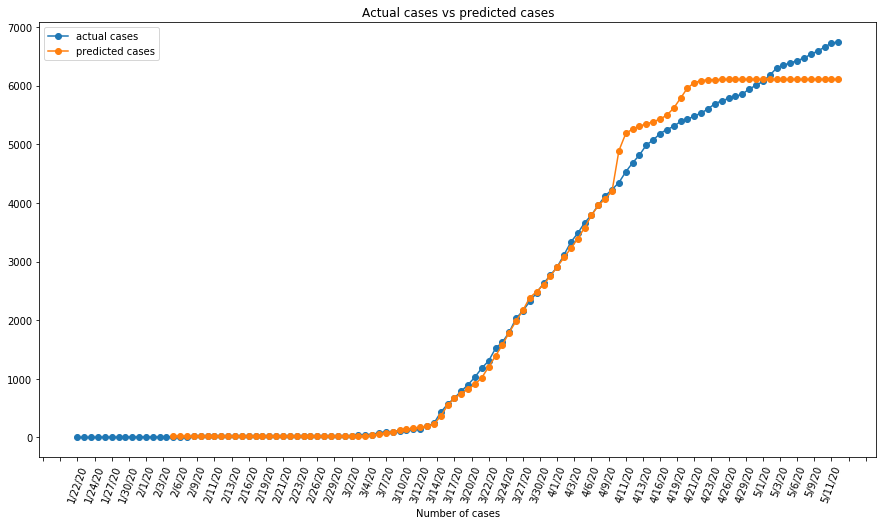

In [30]:
plt.figure(figsize=(15,8))
plt.plot(dates, df_confirmed[df_confirmed['Country/Region'] == 'Malaysia'].to_numpy()[0, 4:], marker='o', label='actual cases')
plt.plot(dates[prev_day:], y_pred, marker='o', label='predicted cases')
plt.title("Actual cases vs predicted cases")
plt.xlabel('Date')
plt.xlabel('Number of cases')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=50))
plt.xticks(rotation=70)
plt.legend()

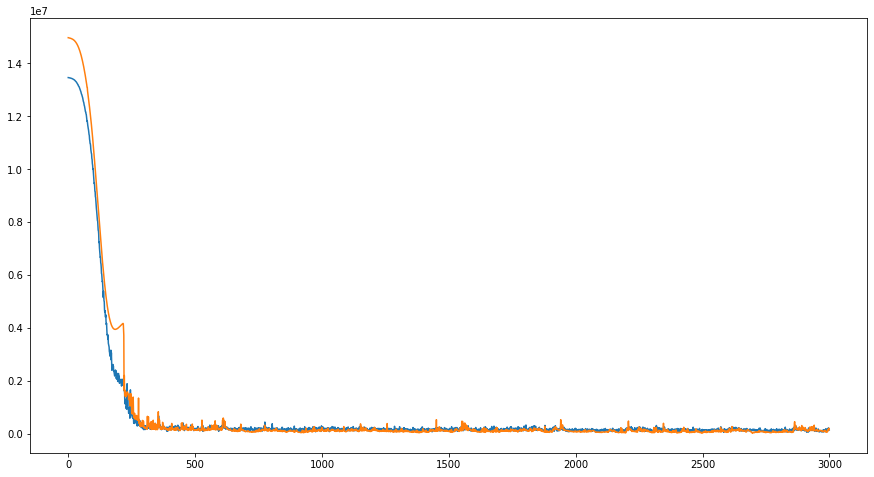

In [28]:
# Model traning loss
plt.figure(figsize=(15,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])